## Import libraries 

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from feature_engine.creation import CyclicalFeatures
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

## Prepare the dataset

In [54]:
url = 'https://opendata.muenchen.de/dataset/5e73a82b-7cfb-40cc-9b30-45fe5a3fa24e/resource/40094bd6-f82d-4979-949b-26c8dc00b9a7/download/220511_monatszahlenmonatszahlen2204_verkehrsunfaelle.csv'
# work with only 2020 and earlier data as the challenge rules suggest
df = pd.read_csv(url)
df = df[df.JAHR<2022].fillna(method="ffill",axis='columns')
df = df[df.MONAT!='Summe'].reset_index()
df['MONAT_INT'] = df['MONAT'].astype(int)

In [70]:
train_df = df[df.JAHR<2021][df.MONATSZAHL=='Alkoholunfälle'][df.AUSPRAEGUNG=='insgesamt'][df.MONAT!='Summe']
test_df = df[df.JAHR==2021][df.MONATSZAHL=='Alkoholunfälle'][df.AUSPRAEGUNG=='insgesamt'][df.MONAT!='Summe']

features_list = ['JAHR','MONAT_INT','VORJAHRESWERT','VERAEND_VORMONAT_PROZENT','VERAEND_VORJAHRESMONAT_PROZENT','ZWOELF_MONATE_MITTELWERT']
X_train, X_val, y_train, y_val = train_test_split(train_df[features_list].values, train_df['WERT'].to_list(), test_size=0.2, random_state=42, shuffle=True)
X_test, y_test = test_df[features_list].values, test_df['WERT'].to_list()

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(201, 6)
(51, 6)
(12, 6)


/home/nurik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/nurik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


## Define a prediction pipeline function

In [ ]:
def prediction_pipeline(model, X_train, X_val, X_test, y_train, y_val, y_test):
    train = {}
    val = {}
    test = {}
    fig, axs = plt.subplots(3, 1, figsize=(15,15))
    for idx, subset in enumerate([train, val, test]):
        pred = model.predict(subset)
        loss = mse(subset, pred, squared=False)
        axs[idx].plot(y_train, label='y_train')
        axs[idx].plot(pred_train, label='pred_train')
        axs[idx].legend(loc='best')
        axs[idx].set_title(model.__name__, fontsize=16)
    plt.show()

## Build a Liner Regression model

In [73]:
from sklearn.linear_model import LinearRegression, Ridge

lr = Ridge(alpha=0.001, fit_intercept=True, normalize=True)
#lr = LinearRegression(alpha=0.01, random_state=42)
lr.fit(X_train, y_train)

/home/nurik/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,


Ridge(alpha=0.001, normalize=True)

5.095579100951441
3.606493695119053
4.7879064893440075


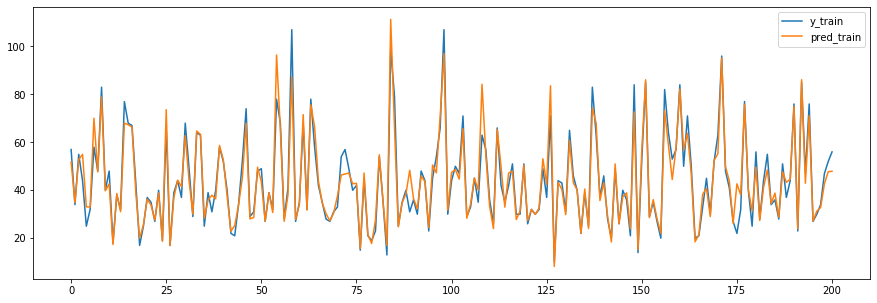

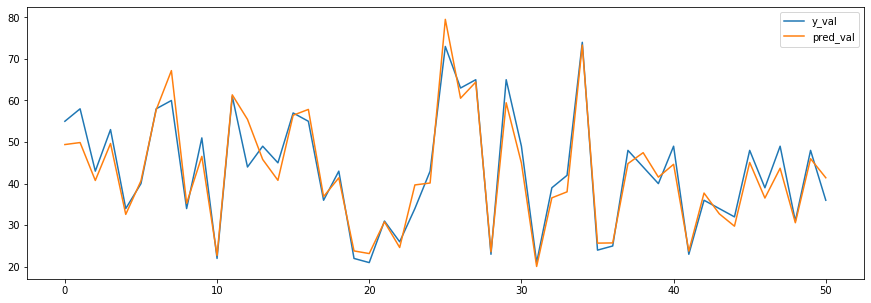

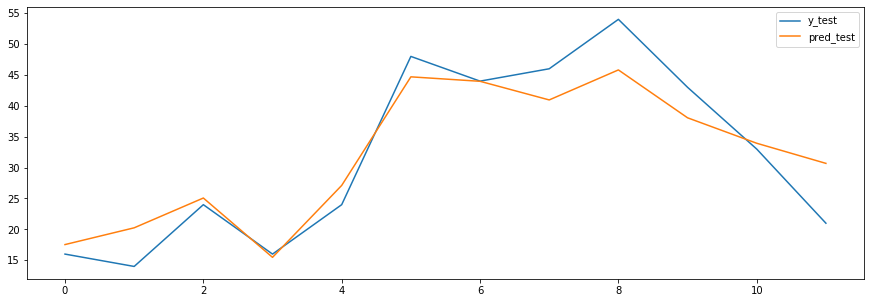

In [74]:
pred_train = lr.predict(X_train)
pred_val = lr.predict(X_val)
pred_test = lr.predict(X_test)

print(mse(y_train, pred_train, squared=False))
print(mse(y_val, pred_val, squared=False))
print(mse(y_test, pred_test, squared=False))

plt.figure(figsize=(15,5))
plt.plot(y_train, label='y_train')
plt.plot(pred_train, label='pred_train')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(y_val, label='y_val')
plt.plot(pred_val, label='pred_val')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(y_test, label='y_test')
plt.plot(pred_test, label='pred_test')
plt.legend(loc='best')
plt.show()

## Build a Random Forest model

In [4]:
rf = RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [5]:
pred_train = rf.predict(X_train)
pred_val = rf.predict(X_val)
pred_test = rf.predict(X_test)

In [6]:
print(mse(y_train, pred_train, squared=False))
print(mse(y_val, pred_val, squared=False))
print(mse(y_test, pred_test, squared=False))

1.8159226647569844
3.310562715037441
4.359775414705059


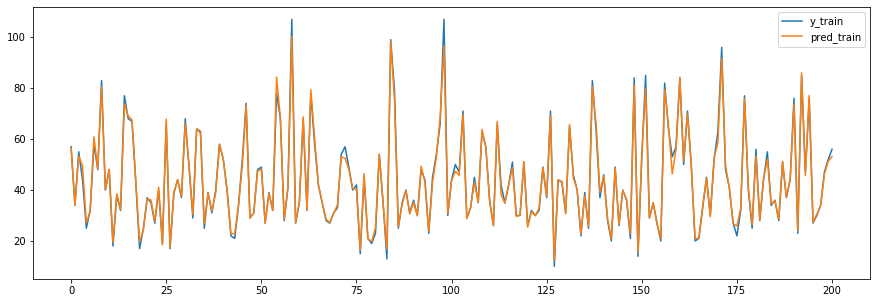

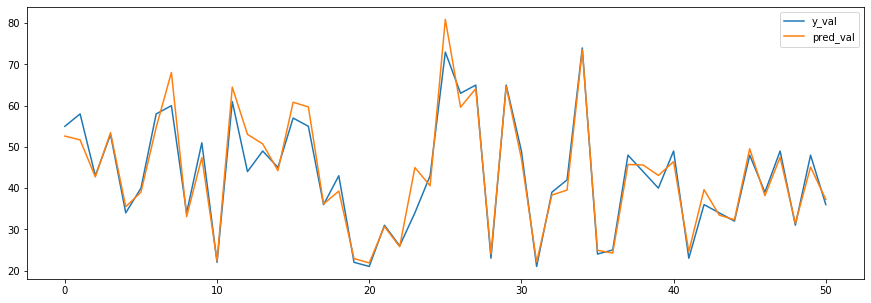

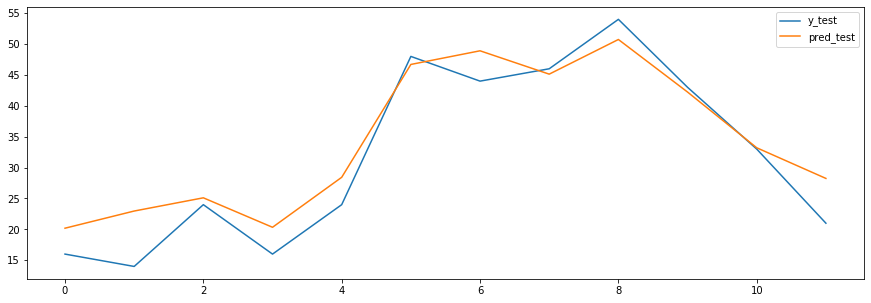

In [7]:
plt.figure(figsize=(15,5))
plt.plot(y_train, label='y_train')
plt.plot(pred_train, label='pred_train')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(y_val, label='y_val')
plt.plot(pred_val, label='pred_val')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(y_test, label='y_test')
plt.plot(pred_test, label='pred_test')
plt.legend(loc='best')
plt.show()

## Build a LightGBM model

In [35]:
#import lightgbm as lgb
import optuna.integration.lightgbm as lgb

In [36]:
X_train_lgb = lgb.Dataset(X_train, label=y_train)
X_val_lgb = lgb.Dataset(X_val, label=y_val)
X_test_lgb = lgb.Dataset(X_test, label=y_test)

In [37]:
#param = {'objective':'regression', 'metric':'rmse', 'num_leaves':'4'}
param = {'objective':'regression', 'metric':'rmse'}

In [38]:
X_train.shape

(201, 8)

In [39]:
#num_round = 1000
bst = lgb.train(param, 
                X_train_lgb,
                valid_sets=X_val_lgb,
                callbacks=[lgb.early_stopping(stopping_rounds=1000)])

[I 2022-11-21 17:20:10,893] A new study created in memory with name: no-name-9935d030-20eb-4e18-b76b-79887bb0a2be
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s][W 2022-11-21 17:20:10,962] Trial 0 failed because of the following error: TypeError("train() got an unexpected keyword argument 'fobj'")
Traceback (most recent call last):
  File "/home/nurik/anaconda3/lib/python3.7/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/home/nurik/anaconda3/lib/python3.7/site-packages/optuna/integration/_lightgbm_tuner/optimize.py", line 248, in __call__
    booster = lgb.train(self.lgbm_params, train_set, **kwargs)
TypeError: train() got an unexpected keyword argument 'fobj'


TypeError: train() got an unexpected keyword argument 'fobj'

In [33]:
bst.params

{'objective': 'regression',
 'metric': 'rmse',
 'num_leaves': '4',
 'num_iterations': 100}

3.121712335630085
3.5491887996955924
4.760259547156725


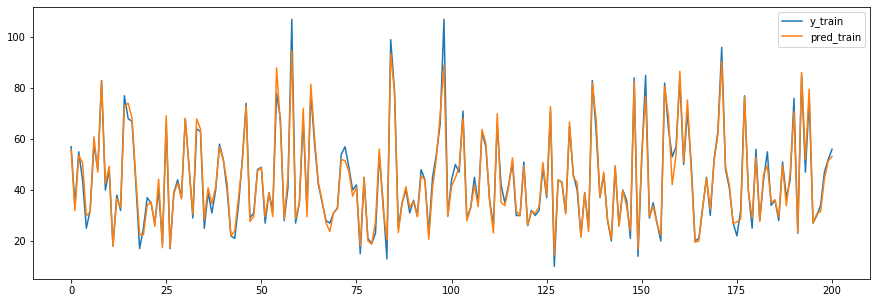

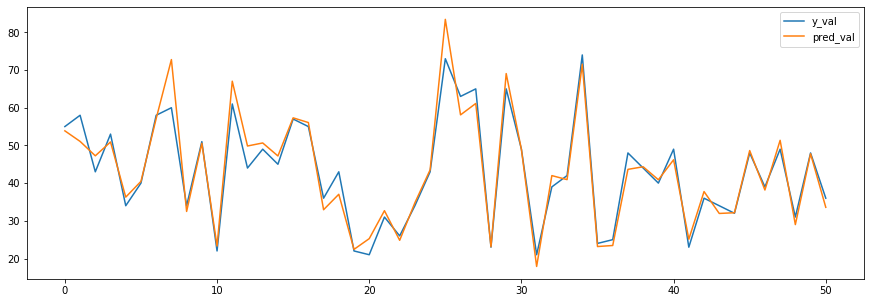

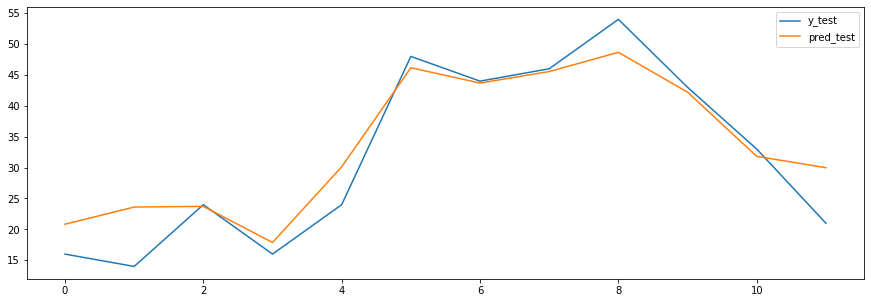

In [34]:
pred_train = bst.predict(X_train).reshape(-1, 1)
pred_val = bst.predict(X_val).reshape(-1, 1)
pred_test = bst.predict(X_test).reshape(-1, 1)

print(mse(y_train, pred_train, squared=False))
print(mse(y_val, pred_val, squared=False))
print(mse(y_test, pred_test, squared=False))

plt.figure(figsize=(15,5))
plt.plot(y_train, label='y_train')
plt.plot(pred_train, label='pred_train')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(y_val, label='y_val')
plt.plot(pred_val, label='pred_val')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(y_test, label='y_test')
plt.plot(pred_test, label='pred_test')
plt.legend(loc='best')
plt.show()

# Build a CatBoost model with optimized hyperparameter tuning

In [48]:
from catboost import CatBoostRegressor, Pool
from optuna.samplers import TPESampler
import optuna

In [65]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 100),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide'])
    }
    cb = CatBoostRegressor(**params, random_seed=42)
    cb.fit(X_train, y_train, eval_set=(X_val, y_val))
    pred_val = cb.predict(X_val).reshape(-1, 1)
    val_rmse = mse(y_val, pred_val, squared=False)
    return val_rmse

In [66]:
sampler = TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=20)

[I 2022-11-21 17:45:25,697] A new study created in memory with name: no-name-6bb20097-39e4-463b-a2fb-15f446981227


0:	learn: 18.4625111	test: 13.4303963	best: 13.4303963 (0)	total: 33.9ms	remaining: 33.9s
1:	learn: 18.1528528	test: 13.2114465	best: 13.2114465 (1)	total: 71.5ms	remaining: 35.7s
2:	learn: 17.7802078	test: 12.8682633	best: 12.8682633 (2)	total: 94.9ms	remaining: 31.5s
3:	learn: 17.1384920	test: 12.4359428	best: 12.4359428 (3)	total: 110ms	remaining: 27.5s
4:	learn: 16.7687882	test: 12.1968518	best: 12.1968518 (4)	total: 146ms	remaining: 29.1s
5:	learn: 16.4175878	test: 11.8605220	best: 11.8605220 (5)	total: 178ms	remaining: 29.4s
6:	learn: 16.1330953	test: 11.6607263	best: 11.6607263 (6)	total: 214ms	remaining: 30.3s
7:	learn: 15.8345749	test: 11.4373007	best: 11.4373007 (7)	total: 270ms	remaining: 33.4s
8:	learn: 15.5694033	test: 11.2367949	best: 11.2367949 (8)	total: 346ms	remaining: 38.1s
9:	learn: 15.2677863	test: 11.0046183	best: 11.0046183 (9)	total: 392ms	remaining: 38.8s
10:	learn: 15.0497886	test: 10.8461244	best: 10.8461244 (10)	total: 457ms	remaining: 41.1s
11:	learn: 14.40

[I 2022-11-21 17:46:16,710] Trial 0 finished with value: 3.574368301841147 and parameters: {'learning_rate': 0.19352465823520762, 'depth': 10, 'l2_leaf_reg': 73.46740023932911, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 3.574368301841147.


0:	learn: 18.7669391	test: 13.6964132	best: 13.6964132 (0)	total: 11.1ms	remaining: 11.1s
1:	learn: 18.5992676	test: 13.5917854	best: 13.5917854 (1)	total: 23.3ms	remaining: 11.6s
2:	learn: 18.4531498	test: 13.4671136	best: 13.4671136 (2)	total: 35.3ms	remaining: 11.7s
3:	learn: 18.2471738	test: 13.3131027	best: 13.3131027 (3)	total: 46ms	remaining: 11.5s
4:	learn: 18.1131792	test: 13.2173968	best: 13.2173968 (4)	total: 55.6ms	remaining: 11.1s
5:	learn: 17.9632306	test: 13.0723277	best: 13.0723277 (5)	total: 67.2ms	remaining: 11.1s
6:	learn: 17.8412117	test: 12.9795299	best: 12.9795299 (6)	total: 77.7ms	remaining: 11s
7:	learn: 17.7033720	test: 12.8677777	best: 12.8677777 (7)	total: 87.5ms	remaining: 10.8s
8:	learn: 17.5356418	test: 12.7419516	best: 12.7419516 (8)	total: 98.3ms	remaining: 10.8s
9:	learn: 17.3894288	test: 12.6565768	best: 12.6565768 (9)	total: 108ms	remaining: 10.7s
10:	learn: 17.2300894	test: 12.5181485	best: 12.5181485 (10)	total: 119ms	remaining: 10.7s
11:	learn: 17.

[I 2022-11-21 17:46:34,127] Trial 1 finished with value: 2.4873791217879058 and parameters: {'learning_rate': 0.03846096996241773, 'depth': 9, 'l2_leaf_reg': 60.510386162577674, 'grow_policy': 'Lossguide'}. Best is trial 1 with value: 2.4873791217879058.


0:	learn: 15.6754951	test: 11.3844623	best: 11.3844623 (0)	total: 4.88ms	remaining: 4.88s
1:	learn: 13.3964101	test: 9.7411048	best: 9.7411048 (1)	total: 10.4ms	remaining: 5.21s
2:	learn: 11.5673458	test: 8.2633449	best: 8.2633449 (2)	total: 15.4ms	remaining: 5.13s
3:	learn: 9.9342641	test: 7.3137266	best: 7.3137266 (3)	total: 19.4ms	remaining: 4.82s
4:	learn: 8.8275384	test: 6.7262950	best: 6.7262950 (4)	total: 24.3ms	remaining: 4.83s
5:	learn: 7.9891076	test: 6.2585008	best: 6.2585008 (5)	total: 29.1ms	remaining: 4.82s
6:	learn: 7.1490362	test: 6.0274650	best: 6.0274650 (6)	total: 33.9ms	remaining: 4.81s
7:	learn: 6.5683451	test: 5.6845491	best: 5.6845491 (7)	total: 38.1ms	remaining: 4.72s
8:	learn: 6.0961840	test: 5.5966126	best: 5.5966126 (8)	total: 42.7ms	remaining: 4.7s
9:	learn: 5.6996056	test: 5.3302071	best: 5.3302071 (9)	total: 47.5ms	remaining: 4.7s
10:	learn: 5.3412015	test: 5.1784752	best: 5.1784752 (10)	total: 52.1ms	remaining: 4.69s
11:	learn: 5.0897170	test: 5.1107764	b

[I 2022-11-21 17:46:40,590] Trial 2 finished with value: 3.2783960656584865 and parameters: {'learning_rate': 0.41789689399220664, 'depth': 4, 'l2_leaf_reg': 19.00067175350296, 'grow_policy': 'Lossguide'}. Best is trial 1 with value: 2.4873791217879058.


990:	learn: 0.0076515	test: 3.2783961	best: 3.2783961 (990)	total: 5.46s	remaining: 49.6ms
991:	learn: 0.0076340	test: 3.2784092	best: 3.2783961 (990)	total: 5.46s	remaining: 44.1ms
992:	learn: 0.0075518	test: 3.2784142	best: 3.2783961 (990)	total: 5.47s	remaining: 38.5ms
993:	learn: 0.0074936	test: 3.2784491	best: 3.2783961 (990)	total: 5.47s	remaining: 33ms
994:	learn: 0.0074778	test: 3.2784429	best: 3.2783961 (990)	total: 5.49s	remaining: 27.6ms
995:	learn: 0.0074543	test: 3.2784628	best: 3.2783961 (990)	total: 5.49s	remaining: 22.1ms
996:	learn: 0.0074481	test: 3.2784647	best: 3.2783961 (990)	total: 5.5s	remaining: 16.5ms
997:	learn: 0.0074375	test: 3.2784847	best: 3.2783961 (990)	total: 5.5s	remaining: 11ms
998:	learn: 0.0074249	test: 3.2784923	best: 3.2783961 (990)	total: 5.51s	remaining: 5.51ms
999:	learn: 0.0074035	test: 3.2785046	best: 3.2783961 (990)	total: 5.51s	remaining: 0us

bestTest = 3.278396066
bestIteration = 990

Shrink model to first 991 iterations.
0:	learn: 18.153

[I 2022-11-21 17:46:55,940] Trial 3 finished with value: 2.3148719707775625 and parameters: {'learning_rate': 0.22165305913463673, 'depth': 5, 'l2_leaf_reg': 61.573436577515565, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 2.3148719707775625.


0:	learn: 17.6127680	test: 12.8047206	best: 12.8047206 (0)	total: 22.6ms	remaining: 22.6s
1:	learn: 16.6569023	test: 12.0585152	best: 12.0585152 (1)	total: 45.6ms	remaining: 22.8s
2:	learn: 15.4603227	test: 11.4180069	best: 11.4180069 (2)	total: 73.6ms	remaining: 24.5s
3:	learn: 14.6073249	test: 10.9492091	best: 10.9492091 (3)	total: 97.7ms	remaining: 24.3s
4:	learn: 13.7108937	test: 10.1506125	best: 10.1506125 (4)	total: 125ms	remaining: 24.9s
5:	learn: 12.8537012	test: 9.5552091	best: 9.5552091 (5)	total: 152ms	remaining: 25.1s
6:	learn: 12.1917030	test: 9.1313637	best: 9.1313637 (6)	total: 177ms	remaining: 25.1s
7:	learn: 11.1461851	test: 8.3781304	best: 8.3781304 (7)	total: 194ms	remaining: 24s
8:	learn: 10.7538236	test: 8.1948860	best: 8.1948860 (8)	total: 222ms	remaining: 24.4s
9:	learn: 10.2883264	test: 7.8511881	best: 7.8511881 (9)	total: 253ms	remaining: 25.1s
10:	learn: 9.7756780	test: 7.5861985	best: 7.5861985 (10)	total: 273ms	remaining: 24.5s
11:	learn: 9.4038641	test: 7.4

[I 2022-11-21 17:47:45,024] Trial 4 finished with value: 2.853216796412992 and parameters: {'learning_rate': 0.2334742922663476, 'depth': 9, 'l2_leaf_reg': 20.767704433677615, 'grow_policy': 'Depthwise'}. Best is trial 3 with value: 2.3148719707775625.


0:	learn: 15.9100876	test: 11.8614006	best: 11.8614006 (0)	total: 4.06ms	remaining: 4.06s
1:	learn: 13.7053838	test: 10.7659478	best: 10.7659478 (1)	total: 8.19ms	remaining: 4.09s
2:	learn: 11.8645667	test: 9.3359600	best: 9.3359600 (2)	total: 14.5ms	remaining: 4.83s
3:	learn: 10.6099219	test: 8.3661668	best: 8.3661668 (3)	total: 18.6ms	remaining: 4.63s
4:	learn: 9.4372891	test: 7.7612518	best: 7.7612518 (4)	total: 22.9ms	remaining: 4.56s
5:	learn: 8.4608602	test: 7.1897472	best: 7.1897472 (5)	total: 28ms	remaining: 4.64s
6:	learn: 7.5310101	test: 6.4679699	best: 6.4679699 (6)	total: 32.3ms	remaining: 4.58s
7:	learn: 6.9355213	test: 6.2550925	best: 6.2550925 (7)	total: 36.6ms	remaining: 4.54s
8:	learn: 6.4022981	test: 6.0702475	best: 6.0702475 (8)	total: 40.6ms	remaining: 4.47s
9:	learn: 5.8483693	test: 5.7041743	best: 5.7041743 (9)	total: 44.8ms	remaining: 4.44s
10:	learn: 5.3853562	test: 5.2939420	best: 5.2939420 (10)	total: 49.1ms	remaining: 4.42s
11:	learn: 4.9580810	test: 5.045440

[I 2022-11-21 17:47:50,970] Trial 5 finished with value: 2.9444988917669153 and parameters: {'learning_rate': 0.3076969774317048, 'depth': 4, 'l2_leaf_reg': 7.4401077055426725, 'grow_policy': 'Depthwise'}. Best is trial 3 with value: 2.3148719707775625.


0:	learn: 18.2389117	test: 13.3051398	best: 13.3051398 (0)	total: 4.01ms	remaining: 4s
1:	learn: 17.5746991	test: 12.8057930	best: 12.8057930 (1)	total: 8.73ms	remaining: 4.35s
2:	learn: 17.0347221	test: 12.4078487	best: 12.4078487 (2)	total: 12.3ms	remaining: 4.1s
3:	learn: 16.4934493	test: 11.9698024	best: 11.9698024 (3)	total: 16.2ms	remaining: 4.03s
4:	learn: 15.8207396	test: 11.4390646	best: 11.4390646 (4)	total: 19.4ms	remaining: 3.85s
5:	learn: 15.1675178	test: 10.9777922	best: 10.9777922 (5)	total: 22.3ms	remaining: 3.69s
6:	learn: 14.7060782	test: 10.6126250	best: 10.6126250 (6)	total: 25.5ms	remaining: 3.62s
7:	learn: 14.2192395	test: 10.2214717	best: 10.2214717 (7)	total: 29.4ms	remaining: 3.65s
8:	learn: 13.8226809	test: 9.8415830	best: 9.8415830 (8)	total: 32.8ms	remaining: 3.62s
9:	learn: 13.3986310	test: 9.5381008	best: 9.5381008 (9)	total: 36ms	remaining: 3.56s
10:	learn: 12.8599013	test: 9.1995402	best: 9.1995402 (10)	total: 39.6ms	remaining: 3.56s
11:	learn: 12.567513

[I 2022-11-21 17:47:55,170] Trial 6 finished with value: 3.092463156051987 and parameters: {'learning_rate': 0.15926074689495165, 'depth': 3, 'l2_leaf_reg': 68.73906962470353, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 2.3148719707775625.


0:	learn: 18.8193557	test: 13.7359081	best: 13.7359081 (0)	total: 30.7ms	remaining: 30.6s
1:	learn: 18.7222548	test: 13.6563553	best: 13.6563553 (1)	total: 57.8ms	remaining: 28.9s
2:	learn: 18.6315159	test: 13.5945317	best: 13.5945317 (2)	total: 85.5ms	remaining: 28.4s
3:	learn: 18.5198704	test: 13.5082078	best: 13.5082078 (3)	total: 115ms	remaining: 28.6s
4:	learn: 18.4330890	test: 13.4412201	best: 13.4412201 (4)	total: 142ms	remaining: 28.3s
5:	learn: 18.3319959	test: 13.3670174	best: 13.3670174 (5)	total: 170ms	remaining: 28.1s
6:	learn: 18.2031359	test: 13.2656922	best: 13.2656922 (6)	total: 180ms	remaining: 25.5s
7:	learn: 18.0934486	test: 13.1775166	best: 13.1775166 (7)	total: 209ms	remaining: 25.9s
8:	learn: 18.0178903	test: 13.1263227	best: 13.1263227 (8)	total: 228ms	remaining: 25.1s
9:	learn: 17.9045948	test: 13.0547302	best: 13.0547302 (9)	total: 260ms	remaining: 25.7s
10:	learn: 17.7975539	test: 12.9642518	best: 12.9642518 (10)	total: 288ms	remaining: 25.9s
11:	learn: 17.68

[I 2022-11-21 17:48:33,385] Trial 7 finished with value: 3.966097762226914 and parameters: {'learning_rate': 0.02685037534645701, 'depth': 10, 'l2_leaf_reg': 26.619218178401674, 'grow_policy': 'SymmetricTree'}. Best is trial 3 with value: 2.3148719707775625.


0:	learn: 18.1726564	test: 13.2484774	best: 13.2484774 (0)	total: 5.68ms	remaining: 5.68s
1:	learn: 17.3762248	test: 12.7562672	best: 12.7562672 (1)	total: 10.3ms	remaining: 5.15s
2:	learn: 16.6578419	test: 12.2619895	best: 12.2619895 (2)	total: 15.3ms	remaining: 5.07s
3:	learn: 15.8852881	test: 11.6819091	best: 11.6819091 (3)	total: 20.2ms	remaining: 5.02s
4:	learn: 15.2273535	test: 11.1408606	best: 11.1408606 (4)	total: 24.8ms	remaining: 4.93s
5:	learn: 14.7594215	test: 10.8005343	best: 10.8005343 (5)	total: 29.3ms	remaining: 4.85s
6:	learn: 14.2510443	test: 10.3595539	best: 10.3595539 (6)	total: 34.4ms	remaining: 4.88s
7:	learn: 13.8554261	test: 10.1246414	best: 10.1246414 (7)	total: 38.7ms	remaining: 4.8s
8:	learn: 13.3839294	test: 9.7856552	best: 9.7856552 (8)	total: 43.1ms	remaining: 4.75s
9:	learn: 12.8985866	test: 9.4877526	best: 9.4877526 (9)	total: 49.4ms	remaining: 4.89s
10:	learn: 12.5309091	test: 9.3033509	best: 9.3033509 (10)	total: 53.6ms	remaining: 4.82s
11:	learn: 12.1

[I 2022-11-21 17:48:39,416] Trial 8 finished with value: 2.7343570148981304 and parameters: {'learning_rate': 0.277888036878207, 'depth': 4, 'l2_leaf_reg': 96.9888781486913, 'grow_policy': 'Depthwise'}. Best is trial 3 with value: 2.3148719707775625.


991:	learn: 0.4200985	test: 2.7377447	best: 2.7366433 (938)	total: 5.05s	remaining: 40.7ms
992:	learn: 0.4185771	test: 2.7372572	best: 2.7366433 (938)	total: 5.05s	remaining: 35.6ms
993:	learn: 0.4174908	test: 2.7365124	best: 2.7365124 (993)	total: 5.06s	remaining: 30.6ms
994:	learn: 0.4173333	test: 2.7365574	best: 2.7365124 (993)	total: 5.07s	remaining: 25.5ms
995:	learn: 0.4162212	test: 2.7356859	best: 2.7356859 (995)	total: 5.07s	remaining: 20.4ms
996:	learn: 0.4157184	test: 2.7353957	best: 2.7353957 (996)	total: 5.08s	remaining: 15.3ms
997:	learn: 0.4146644	test: 2.7348876	best: 2.7348876 (997)	total: 5.08s	remaining: 10.2ms
998:	learn: 0.4141681	test: 2.7343570	best: 2.7343570 (998)	total: 5.09s	remaining: 5.09ms
999:	learn: 0.4134914	test: 2.7344425	best: 2.7343570 (998)	total: 5.09s	remaining: 0us

bestTest = 2.734357015
bestIteration = 998

Shrink model to first 999 iterations.
0:	learn: 16.0164902	test: 11.6945955	best: 11.6945955 (0)	total: 15.4ms	remaining: 15.4s
1:	learn: 1

[I 2022-11-21 17:48:56,726] Trial 9 finished with value: 2.8359388115188326 and parameters: {'learning_rate': 0.30297098961743174, 'depth': 10, 'l2_leaf_reg': 9.76075770314003, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 2.3148719707775625.


0:	learn: 16.3731984	test: 12.0943523	best: 12.0943523 (0)	total: 11.1ms	remaining: 11.1s
1:	learn: 14.4162476	test: 10.6250583	best: 10.6250583 (1)	total: 20.8ms	remaining: 10.4s
2:	learn: 12.6685585	test: 9.5871535	best: 9.5871535 (2)	total: 30.3ms	remaining: 10.1s
3:	learn: 11.6790005	test: 8.8308141	best: 8.8308141 (3)	total: 39.7ms	remaining: 9.89s
4:	learn: 10.3963177	test: 8.0270660	best: 8.0270660 (4)	total: 49.9ms	remaining: 9.93s
5:	learn: 9.6205003	test: 7.4247102	best: 7.4247102 (5)	total: 60.2ms	remaining: 9.97s
6:	learn: 8.9202976	test: 6.8207784	best: 6.8207784 (6)	total: 69.8ms	remaining: 9.91s
7:	learn: 8.2281458	test: 6.4458647	best: 6.4458647 (7)	total: 78.7ms	remaining: 9.76s
8:	learn: 7.6692977	test: 6.1855508	best: 6.1855508 (8)	total: 90.2ms	remaining: 9.93s
9:	learn: 7.2529332	test: 5.9571509	best: 5.9571509 (9)	total: 98.6ms	remaining: 9.76s
10:	learn: 6.8388638	test: 5.6643761	best: 5.6643761 (10)	total: 110ms	remaining: 9.9s
11:	learn: 6.4139365	test: 5.37368

[I 2022-11-21 17:49:10,450] Trial 10 finished with value: 2.8858471728858683 and parameters: {'learning_rate': 0.4731169066728894, 'depth': 6, 'l2_leaf_reg': 43.56774265198179, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 2.3148719707775625.


0:	learn: 18.8709855	test: 13.7781869	best: 13.7781869 (0)	total: 13.7ms	remaining: 13.7s
1:	learn: 18.7798190	test: 13.7074965	best: 13.7074965 (1)	total: 27.6ms	remaining: 13.8s
2:	learn: 18.6850408	test: 13.6164998	best: 13.6164998 (2)	total: 48.8ms	remaining: 16.2s
3:	learn: 18.6252393	test: 13.5674300	best: 13.5674300 (3)	total: 59.9ms	remaining: 14.9s
4:	learn: 18.5514250	test: 13.5164155	best: 13.5164155 (4)	total: 72ms	remaining: 14.3s
5:	learn: 18.4982865	test: 13.4761914	best: 13.4761914 (5)	total: 83.7ms	remaining: 13.9s
6:	learn: 18.4374425	test: 13.4389361	best: 13.4389361 (6)	total: 95.6ms	remaining: 13.6s
7:	learn: 18.3807638	test: 13.3896033	best: 13.3896033 (7)	total: 107ms	remaining: 13.3s
8:	learn: 18.3149547	test: 13.3328754	best: 13.3328754 (8)	total: 121ms	remaining: 13.3s
9:	learn: 18.2421488	test: 13.2662067	best: 13.2662067 (9)	total: 133ms	remaining: 13.2s
10:	learn: 18.1677378	test: 13.1965376	best: 13.1965376 (10)	total: 144ms	remaining: 12.9s
11:	learn: 18.

[I 2022-11-21 17:49:26,592] Trial 11 finished with value: 2.9635019424534947 and parameters: {'learning_rate': 0.01626643985051671, 'depth': 7, 'l2_leaf_reg': 55.179515280874924, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 2.3148719707775625.


0:	learn: 18.5521208	test: 13.5611997	best: 13.5611997 (0)	total: 14.1ms	remaining: 14.1s
1:	learn: 18.1615956	test: 13.2826346	best: 13.2826346 (1)	total: 25.9ms	remaining: 12.9s
2:	learn: 17.7126842	test: 12.8532800	best: 12.8532800 (2)	total: 36.5ms	remaining: 12.1s
3:	learn: 17.4314073	test: 12.5702562	best: 12.5702562 (3)	total: 47.7ms	remaining: 11.9s
4:	learn: 17.1716322	test: 12.3335226	best: 12.3335226 (4)	total: 58.5ms	remaining: 11.6s
5:	learn: 16.9556024	test: 12.1833452	best: 12.1833452 (5)	total: 69.4ms	remaining: 11.5s
6:	learn: 16.5998742	test: 11.9466892	best: 11.9466892 (6)	total: 80.3ms	remaining: 11.4s
7:	learn: 16.3287195	test: 11.7622656	best: 11.7622656 (7)	total: 92.1ms	remaining: 11.4s
8:	learn: 16.0868257	test: 11.5663981	best: 11.5663981 (8)	total: 105ms	remaining: 11.6s
9:	learn: 15.8130231	test: 11.3455762	best: 11.3455762 (9)	total: 116ms	remaining: 11.5s
10:	learn: 15.5992006	test: 11.1342553	best: 11.1342553 (10)	total: 126ms	remaining: 11.4s
11:	learn: 

[I 2022-11-21 17:49:43,654] Trial 12 finished with value: 2.357473700435977 and parameters: {'learning_rate': 0.1008699517542499, 'depth': 7, 'l2_leaf_reg': 80.20789793742367, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 2.3148719707775625.


0:	learn: 18.5145092	test: 13.5253464	best: 13.5253464 (0)	total: 17.4ms	remaining: 17.4s
1:	learn: 18.1660258	test: 13.2731183	best: 13.2731183 (1)	total: 32.4ms	remaining: 16.2s
2:	learn: 17.7749570	test: 12.9909994	best: 12.9909994 (2)	total: 48.7ms	remaining: 16.2s
3:	learn: 17.4936921	test: 12.7268927	best: 12.7268927 (3)	total: 64.4ms	remaining: 16s
4:	learn: 17.0411530	test: 12.3589049	best: 12.3589049 (4)	total: 79.8ms	remaining: 15.9s
5:	learn: 16.7426132	test: 12.1288697	best: 12.1288697 (5)	total: 96.7ms	remaining: 16s
6:	learn: 16.4440735	test: 11.8915965	best: 11.8915965 (6)	total: 123ms	remaining: 17.4s
7:	learn: 16.2447438	test: 11.7562079	best: 11.7562079 (7)	total: 146ms	remaining: 18.1s
8:	learn: 15.8348189	test: 11.4513229	best: 11.4513229 (8)	total: 170ms	remaining: 18.7s
9:	learn: 15.4516789	test: 11.1036624	best: 11.1036624 (9)	total: 184ms	remaining: 18.2s
10:	learn: 15.2442208	test: 10.9602139	best: 10.9602139 (10)	total: 197ms	remaining: 17.8s
11:	learn: 14.951

[I 2022-11-21 17:50:05,924] Trial 13 finished with value: 2.482224278890223 and parameters: {'learning_rate': 0.11938448268176423, 'depth': 6, 'l2_leaf_reg': 86.43108555792958, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 2.3148719707775625.


0:	learn: 18.4320341	test: 13.4815523	best: 13.4815523 (0)	total: 14.7ms	remaining: 14.7s
1:	learn: 17.8883403	test: 13.0761289	best: 13.0761289 (1)	total: 24.2ms	remaining: 12.1s
2:	learn: 17.3548554	test: 12.6388616	best: 12.6388616 (2)	total: 42.6ms	remaining: 14.2s
3:	learn: 16.7614646	test: 12.0561550	best: 12.0561550 (3)	total: 58.5ms	remaining: 14.6s
4:	learn: 16.5060239	test: 11.8617754	best: 11.8617754 (4)	total: 69.8ms	remaining: 13.9s
5:	learn: 16.0343552	test: 11.5497191	best: 11.5497191 (5)	total: 82.6ms	remaining: 13.7s
6:	learn: 15.7267488	test: 11.3114516	best: 11.3114516 (6)	total: 96.1ms	remaining: 13.6s
7:	learn: 15.3684823	test: 11.0635896	best: 11.0635896 (7)	total: 108ms	remaining: 13.4s
8:	learn: 14.9307628	test: 10.6933546	best: 10.6933546 (8)	total: 119ms	remaining: 13.1s
9:	learn: 14.5943913	test: 10.3990533	best: 10.3990533 (9)	total: 129ms	remaining: 12.8s
10:	learn: 14.3327667	test: 10.2253961	best: 10.2253961 (10)	total: 140ms	remaining: 12.6s
11:	learn: 1

[I 2022-11-21 17:50:30,907] Trial 14 finished with value: 2.3831798834016653 and parameters: {'learning_rate': 0.08842638551586074, 'depth': 7, 'l2_leaf_reg': 40.71393147992628, 'grow_policy': 'Lossguide'}. Best is trial 3 with value: 2.3148719707775625.


0:	learn: 17.7355301	test: 12.8301003	best: 12.8301003 (0)	total: 8.58ms	remaining: 8.57s
1:	learn: 16.7945300	test: 12.1958383	best: 12.1958383 (1)	total: 12.4ms	remaining: 6.21s
2:	learn: 15.9075251	test: 11.5976762	best: 11.5976762 (2)	total: 15.9ms	remaining: 5.29s
3:	learn: 15.0956565	test: 11.0601742	best: 11.0601742 (3)	total: 19.9ms	remaining: 4.96s
4:	learn: 14.3674819	test: 10.5296650	best: 10.5296650 (4)	total: 23.7ms	remaining: 4.72s
5:	learn: 13.7292567	test: 10.0247091	best: 10.0247091 (5)	total: 27.2ms	remaining: 4.51s
6:	learn: 13.1040039	test: 9.7178268	best: 9.7178268 (6)	total: 30.9ms	remaining: 4.38s
7:	learn: 12.5205761	test: 9.3440809	best: 9.3440809 (7)	total: 34.9ms	remaining: 4.33s
8:	learn: 11.8821487	test: 8.8542272	best: 8.8542272 (8)	total: 38.4ms	remaining: 4.23s
9:	learn: 11.3850439	test: 8.4883819	best: 8.4883819 (9)	total: 42ms	remaining: 4.16s
10:	learn: 10.8941554	test: 8.1256350	best: 8.1256350 (10)	total: 45.3ms	remaining: 4.07s
11:	learn: 10.458453

[I 2022-11-21 17:50:37,191] Trial 15 finished with value: 2.56172295697612 and parameters: {'learning_rate': 0.34639603683417575, 'depth': 5, 'l2_leaf_reg': 78.91674684248571, 'grow_policy': 'SymmetricTree'}. Best is trial 3 with value: 2.3148719707775625.


0:	learn: 18.2353126	test: 13.3168814	best: 13.3168814 (0)	total: 14.6ms	remaining: 14.6s
1:	learn: 17.6082401	test: 12.8885929	best: 12.8885929 (1)	total: 28.2ms	remaining: 14.1s
2:	learn: 17.0334797	test: 12.3717638	best: 12.3717638 (2)	total: 48.3ms	remaining: 16.1s
3:	learn: 16.5922922	test: 11.9997050	best: 11.9997050 (3)	total: 98.1ms	remaining: 24.4s
4:	learn: 16.2927373	test: 11.7737611	best: 11.7737611 (4)	total: 116ms	remaining: 23s
5:	learn: 15.8509011	test: 11.4845827	best: 11.4845827 (5)	total: 133ms	remaining: 22.1s
6:	learn: 15.2282984	test: 10.9551250	best: 10.9551250 (6)	total: 159ms	remaining: 22.5s
7:	learn: 14.7349146	test: 10.5323992	best: 10.5323992 (7)	total: 172ms	remaining: 21.4s
8:	learn: 14.3724999	test: 10.3029791	best: 10.3029791 (8)	total: 204ms	remaining: 22.4s
9:	learn: 13.8952884	test: 9.9914743	best: 9.9914743 (9)	total: 242ms	remaining: 24s
10:	learn: 13.4017297	test: 9.6483070	best: 9.6483070 (10)	total: 256ms	remaining: 23s
11:	learn: 12.9950660	tes

[I 2022-11-21 17:50:58,389] Trial 16 finished with value: 2.2657016339519114 and parameters: {'learning_rate': 0.20688028647165813, 'depth': 8, 'l2_leaf_reg': 97.6090483625423, 'grow_policy': 'Lossguide'}. Best is trial 16 with value: 2.2657016339519114.


0:	learn: 18.2264950	test: 13.3106907	best: 13.3106907 (0)	total: 13.5ms	remaining: 13.5s
1:	learn: 17.5929960	test: 12.8783231	best: 12.8783231 (1)	total: 25.7ms	remaining: 12.8s
2:	learn: 17.0121093	test: 12.3557747	best: 12.3557747 (2)	total: 37.9ms	remaining: 12.6s
3:	learn: 16.5674520	test: 11.9810771	best: 11.9810771 (3)	total: 47.3ms	remaining: 11.8s
4:	learn: 16.2663056	test: 11.7540950	best: 11.7540950 (4)	total: 60ms	remaining: 11.9s
5:	learn: 15.8211700	test: 11.4631747	best: 11.4631747 (5)	total: 73.2ms	remaining: 12.1s
6:	learn: 15.1918664	test: 10.9266179	best: 10.9266179 (6)	total: 82.7ms	remaining: 11.7s
7:	learn: 14.8036658	test: 10.6426121	best: 10.6426121 (7)	total: 92.3ms	remaining: 11.4s
8:	learn: 14.2193092	test: 10.1804394	best: 10.1804394 (8)	total: 104ms	remaining: 11.4s
9:	learn: 13.7752317	test: 9.9574057	best: 9.9574057 (9)	total: 115ms	remaining: 11.4s
10:	learn: 13.2791710	test: 9.6289722	best: 9.6289722 (10)	total: 127ms	remaining: 11.4s
11:	learn: 12.946

[I 2022-11-21 17:51:15,452] Trial 17 finished with value: 2.3467764667770536 and parameters: {'learning_rate': 0.2128951795485105, 'depth': 8, 'l2_leaf_reg': 99.9368814255136, 'grow_policy': 'Lossguide'}. Best is trial 16 with value: 2.2657016339519114.


0:	learn: 17.6062658	test: 12.7508778	best: 12.7508778 (0)	total: 2.67ms	remaining: 2.67s
1:	learn: 16.7559452	test: 12.1815918	best: 12.1815918 (1)	total: 7.03ms	remaining: 3.51s
2:	learn: 16.0941122	test: 11.7271528	best: 11.7271528 (2)	total: 10.3ms	remaining: 3.42s
3:	learn: 15.4787078	test: 11.2627106	best: 11.2627106 (3)	total: 14ms	remaining: 3.5s
4:	learn: 14.5316694	test: 10.6898255	best: 10.6898255 (4)	total: 17.2ms	remaining: 3.43s
5:	learn: 13.8959313	test: 10.2049028	best: 10.2049028 (5)	total: 20.8ms	remaining: 3.45s
6:	learn: 13.3909128	test: 9.9591130	best: 9.9591130 (6)	total: 24.4ms	remaining: 3.46s
7:	learn: 12.8276590	test: 9.5925527	best: 9.5925527 (7)	total: 27.5ms	remaining: 3.41s
8:	learn: 12.2291016	test: 9.1280665	best: 9.1280665 (8)	total: 30.8ms	remaining: 3.39s
9:	learn: 11.7522162	test: 8.8128684	best: 8.8128684 (9)	total: 34.9ms	remaining: 3.46s
10:	learn: 11.2931940	test: 8.4824554	best: 8.4824554 (10)	total: 38.2ms	remaining: 3.43s
11:	learn: 10.9816256

[I 2022-11-21 17:51:19,808] Trial 18 finished with value: 2.925007815308786 and parameters: {'learning_rate': 0.34087941982425063, 'depth': 5, 'l2_leaf_reg': 87.24350259830418, 'grow_policy': 'SymmetricTree'}. Best is trial 16 with value: 2.2657016339519114.


995:	learn: 0.6303009	test: 2.9259475	best: 2.9259475 (995)	total: 3.43s	remaining: 13.8ms
996:	learn: 0.6292384	test: 2.9255849	best: 2.9255849 (996)	total: 3.43s	remaining: 10.3ms
997:	learn: 0.6272941	test: 2.9263087	best: 2.9255849 (996)	total: 3.44s	remaining: 6.88ms
998:	learn: 0.6265882	test: 2.9260358	best: 2.9255849 (996)	total: 3.44s	remaining: 3.44ms
999:	learn: 0.6260142	test: 2.9250078	best: 2.9250078 (999)	total: 3.44s	remaining: 0us

bestTest = 2.925007815
bestIteration = 999

0:	learn: 17.9749746	test: 13.1690885	best: 13.1690885 (0)	total: 18.3ms	remaining: 18.3s
1:	learn: 17.2020167	test: 12.7243141	best: 12.7243141 (1)	total: 42.8ms	remaining: 21.3s
2:	learn: 16.5936466	test: 12.1772578	best: 12.1772578 (2)	total: 61.8ms	remaining: 20.5s
3:	learn: 16.0050170	test: 11.8711506	best: 11.8711506 (3)	total: 84.2ms	remaining: 21s
4:	learn: 15.3433989	test: 11.3440743	best: 11.3440743 (4)	total: 106ms	remaining: 21.1s
5:	learn: 14.8429520	test: 10.9116026	best: 10.9116026 (

[I 2022-11-21 17:51:47,416] Trial 19 finished with value: 3.2663300362904395 and parameters: {'learning_rate': 0.17130364762925074, 'depth': 8, 'l2_leaf_reg': 33.67811002894688, 'grow_policy': 'Depthwise'}. Best is trial 16 with value: 2.2657016339519114.


In [67]:
study.best_params

{'learning_rate': 0.20688028647165813,
 'depth': 8,
 'l2_leaf_reg': 97.6090483625423,
 'grow_policy': 'Lossguide'}

In [68]:
cb = CatBoostRegressor(**study.best_params, random_seed=42)
cb.fit(X_train, y_train, eval_set=(X_val, y_val))

0:	learn: 18.2353126	test: 13.3168814	best: 13.3168814 (0)	total: 15.5ms	remaining: 15.4s
1:	learn: 17.6082401	test: 12.8885929	best: 12.8885929 (1)	total: 27.1ms	remaining: 13.5s
2:	learn: 17.0334797	test: 12.3717638	best: 12.3717638 (2)	total: 43.1ms	remaining: 14.3s
3:	learn: 16.5922922	test: 11.9997050	best: 11.9997050 (3)	total: 54.8ms	remaining: 13.6s
4:	learn: 16.2927373	test: 11.7737611	best: 11.7737611 (4)	total: 77.5ms	remaining: 15.4s
5:	learn: 15.8509011	test: 11.4845827	best: 11.4845827 (5)	total: 89.5ms	remaining: 14.8s
6:	learn: 15.2282984	test: 10.9551250	best: 10.9551250 (6)	total: 99.1ms	remaining: 14.1s
7:	learn: 14.7349146	test: 10.5323992	best: 10.5323992 (7)	total: 111ms	remaining: 13.8s
8:	learn: 14.3724999	test: 10.3029791	best: 10.3029791 (8)	total: 124ms	remaining: 13.6s
9:	learn: 13.8952884	test: 9.9914743	best: 9.9914743 (9)	total: 138ms	remaining: 13.7s
10:	learn: 13.4017297	test: 9.6483070	best: 9.6483070 (10)	total: 150ms	remaining: 13.5s
11:	learn: 12.99

0.23825484507259057
2.2657016339519114
3.2362557258514593


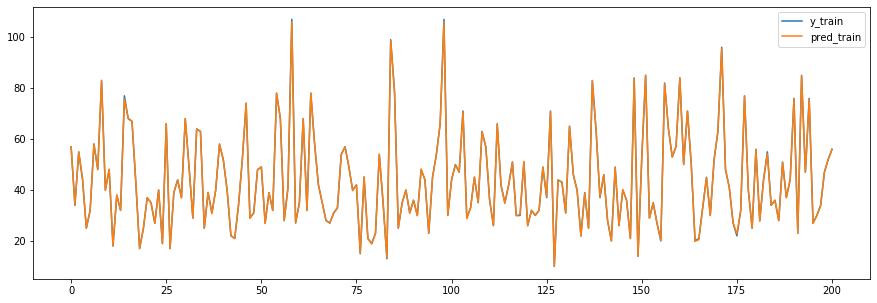

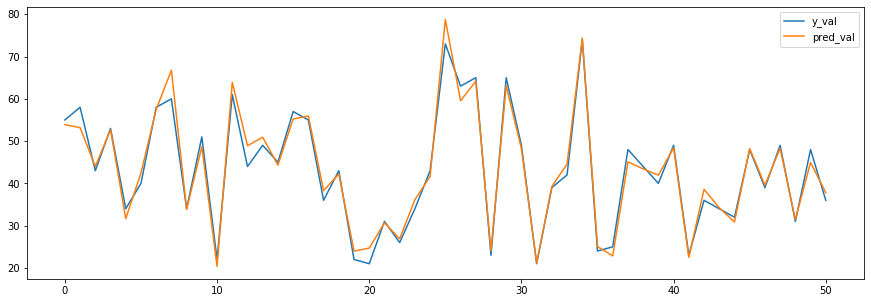

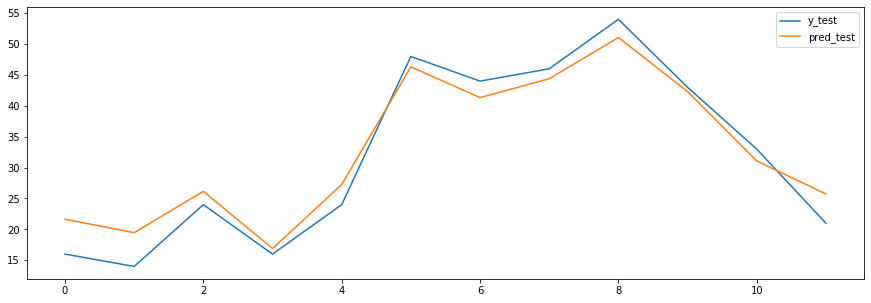

In [75]:
pred_train = cb.predict(X_train)
pred_val = cb.predict(X_val)
pred_test = cb.predict(X_test)

print(mse(y_train, pred_train, squared=False))
print(mse(y_val, pred_val, squared=False))
print(mse(y_test, pred_test, squared=False))

plt.figure(figsize=(15,5))
plt.plot(y_train, label='y_train')
plt.plot(pred_train, label='pred_train')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(y_val, label='y_val')
plt.plot(pred_val, label='pred_val')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(y_test, label='y_test')
plt.plot(pred_test, label='pred_test')
plt.legend(loc='best')
plt.show()